In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using Zygote, Lux, ComponentArrays, Plots, QuadGK, Interpolations, Optimisers, NNlib
using Random: Xoshiro
using MLUtils: DataLoader

# Load the dataset

In [3]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [4]:
using Base: @kwdef

In [5]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [6]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [7]:
data_dir = "pixel_data/"

"pixel_data/"

In [8]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [9]:
q, ylocal, pt = get_samples(data_dir, 1:2)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [10]:
q_test, ylocal_test, pt_test = get_samples(data_dir, 3);

In [11]:
q |> size

(20, 13, 21, 99991)

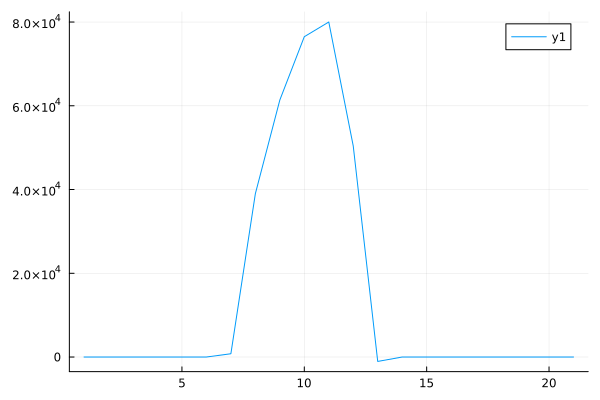

In [12]:
plot(sum(q[:,:,:,128], dims=(1,2)) |> vec)

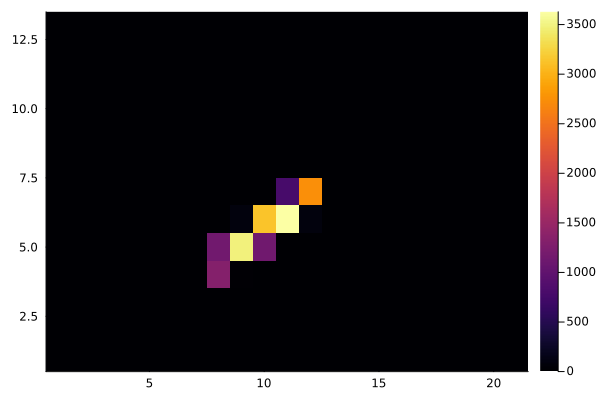

In [13]:
heatmap(q[12,:,:,128])

In [14]:
ylocal |> size

(99991,)

In [15]:
pt |> size

(99991,)

In [16]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [17]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [18]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [19]:
x |> size

(20, 13, 21, 128)

In [20]:
n_px = size(x, 2) * size(x,3)
n_in = n_px + 1

274

# Set up the model

In [41]:
function process_inputs(x, y_local)
    #x = scale_charge(x)
    x = sum(x, dims=(3))
    n_samples = size(x, 1) * size(x, 2)
    n_batch = size(x, 4)
    x = reshape(x, (n_px, n_batch))
    y_local = reshape(y_local, (1, n_batch))

    x = cat(x, y_local, dims = 1)
    return x
end

process_inputs (generic function with 1 method)

In [42]:
process_inputs(x, xl)

261×128 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  ⋮                                      ⋱  ⋮                  
  0.0       0.0       0.0  

In [43]:
model = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    Dense(n_in => 128, relu),
    Dense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(261, affine=true, track_stats=true),  # 522 parameters, plus 523
    layer_2 = Dense(261 => 128, relu),  # 33_536 parameters
    layer_3 = Dense(128 => 3),          # 387 parameters
)         # Total: 34_445 parameters,
          #        plus 523 states.

In [44]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, model)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = (weight = Float32[-0.011305904 0.09815855 … -0.08636455 0.08484003; -0.0810802 0.066883676 … 0.008028206 -0.048152152; … ; 0.088404946 -0.11229569 … 0.11139618 -0.020261057; 0.04923797 -0.076652385 … -0.02740879 0.12321888], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = Float32[0.13702868 0.101796284 … -0.05596938 0.085558705; -0.0332754 -0.17838912 … 0.06668846 0.05473953; 0.076739706 -0.17085312 … -0.16301952 0.21299712], bias = Float32[0.0; 0.0; 0.0;;])), (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [45]:
y_naive, _ = model(process_inputs(x, xl), ps, st)

([-0.5013753295624438 -0.266241247277303 … -0.3088431367627476 -0.26810390460012834; -0.6300497399244204 -0.05200704663507702 … 0.07436951966276534 0.19814230055179316; 0.08744869550031906 -0.04607044511492701 … -0.16623383829476324 0.28874914570925764], (layer_1 = (running_mean = [0.0, 0.0, 0.0, 0.0, 0.00023437500349245968, 0.05453125081257895, 0.01359375020256266, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.9000702886591898, 4.662564746791668, 1.098751701560718, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421  …  0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [46]:
y_naive |> size

(3, 128)

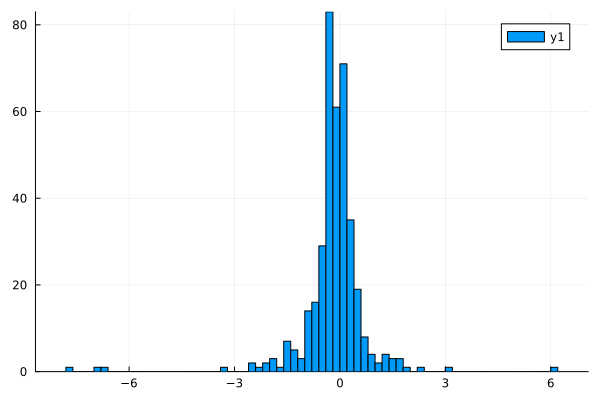

In [47]:
histogram(y_naive |> vec)

In [48]:
using Statistics: std, median, mean

In [49]:
using OneHotArrays

In [50]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [51]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [52]:
labels = momentum_to_label(pt)

3×99991 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  ⋅

In [53]:
logitcrossentropy(y_pred, y) = mean(-1 * sum(y .* logsoftmax(y_pred); dims=1))

logitcrossentropy (generic function with 1 method)

In [54]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = logitcrossentropy(y_pred, y)
    return loss, st
end

loss (generic function with 1 method)

In [55]:
@time loss(x, xl, y, model, ps, st, 0.2)

  0.076353 seconds (19.03 k allocations: 2.192 MiB, 96.88% compilation time)


(1.1271271514814563, (layer_1 = (running_mean = [0.0, 0.0, 0.0, 0.0, 0.00023437500349245968, 0.05453125081257895, 0.01359375020256266, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.9000702886591898, 4.662564746791668, 1.098751701560718, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421  …  0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [56]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [57]:
@time loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 10)

[ Info: Constructing model and starting training


 42.401798 seconds (6.13 M allocations: 117.030 GiB, 14.68% gc time, 1.82% compilation time: 21% of which was recompilation)


(Any[0.8351611768423041, 0.7848662134677522, 0.7652476515219051, 0.7530583928798679, 0.7445431295558399, 0.7380362964927526, 0.7327375132327211, 0.7282299136027719, 0.7239923407027486, 0.7205422148498812], (layer_1 = (scale = Float32[0.99088526, 0.94070536, 0.9578731, 0.9247321, 0.9453787, 0.92531353, 0.88692105, 0.92977124, 0.92079204, 0.9466844  …  0.9516282, 0.9611638, 0.94165814, 0.9699885, 0.9679644, 0.98873526, 0.97484106, 0.9561746, 0.9610995, 1.3132968], bias = Float32[-0.04704753, 0.042655706, -0.11735876, -0.038617086, 0.014575045, 0.028864395, -0.074964054, -0.104462504, 0.09305353, 0.041971967  …  -0.057815745, -0.04465457, -0.007142558, 0.08756332, -0.077544406, 0.09659233, -0.0984005, 0.104061484, 0.099513724, 0.07087584]), layer_2 = (weight = Float32[-0.04713226 0.08547163 … -0.107466325 -0.10305387; -0.072096445 0.11367238 … 0.0044537694 -0.11930277; … ; 0.11480218 -0.0878317 … 0.10432926 0.013792898; 0.010835385 -0.104672834 … -0.05337054 -0.043135583], bias = Float32[

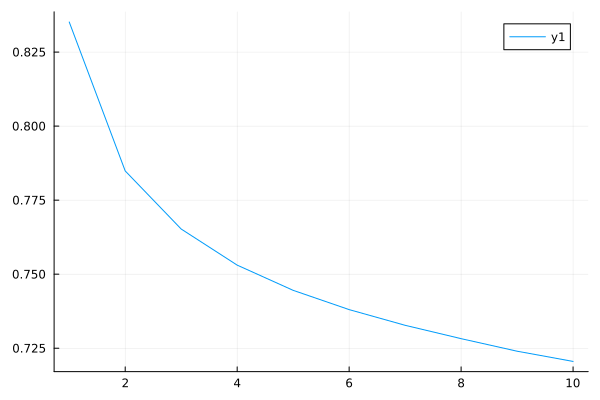

In [59]:
plot(loss_history)

In [60]:
loss_history2, pst2, stt2 = train(model, pst, stt, train_loader, 0.2, epochs = 190)

[ Info: Constructing model and starting training


(Any[0.7172998551086309, 0.7140878275922335, 0.7113378149349963, 0.7089037614498103, 0.7066258893056362, 0.7043222610980454, 0.7022979870576064, 0.7002242920979447, 0.698248915186476, 0.6963334258432706  …  0.5975521059612483, 0.5970679754202904, 0.5969695104806203, 0.5967034763892843, 0.5965638221320634, 0.5963064961519332, 0.5960516324644507, 0.5958866932973121, 0.5955784907839436, 0.5953474743659185], (layer_1 = (scale = Float32[1.39201, 1.2086112, 0.9626954, 1.0835932, 1.3330107, 1.0416092, 1.1132749, 0.41252127, 0.61224633, 0.61865246  …  0.81711286, 0.5203546, 0.46733955, 0.7398241, 0.40004006, 0.8338877, 0.40611663, 0.81809664, 0.7170966, 2.2101545], bias = Float32[0.0013261039, 0.11334316, -0.039981697, 0.06445573, 0.13166486, 0.107162476, -0.06286069, -0.039930448, 0.1698032, 0.15540527  …  -0.04960632, 0.005429891, 0.020557921, 0.15530322, -0.02392439, 0.13646151, -0.08071756, 0.16430429, 0.14908336, 0.030645054]), layer_2 = (weight = Float32[-0.01581689 0.048270416 … -0.1019

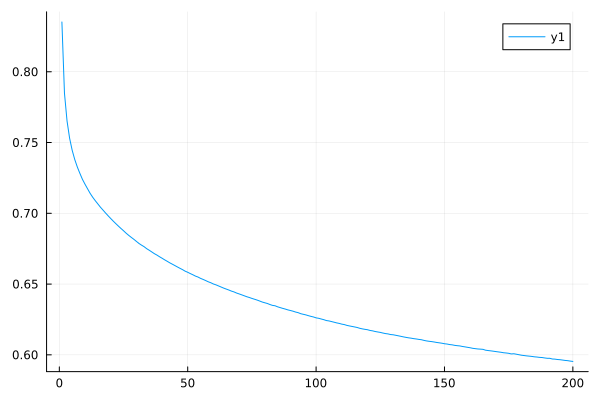

In [61]:
plot(vcat(loss_history, loss_history2))

In [62]:
pst = pst2

(layer_1 = (scale = Float32[1.39201, 1.2086112, 0.9626954, 1.0835932, 1.3330107, 1.0416092, 1.1132749, 0.41252127, 0.61224633, 0.61865246  …  0.81711286, 0.5203546, 0.46733955, 0.7398241, 0.40004006, 0.8338877, 0.40611663, 0.81809664, 0.7170966, 2.2101545], bias = Float32[0.0013261039, 0.11334316, -0.039981697, 0.06445573, 0.13166486, 0.107162476, -0.06286069, -0.039930448, 0.1698032, 0.15540527  …  -0.04960632, 0.005429891, 0.020557921, 0.15530322, -0.02392439, 0.13646151, -0.08071756, 0.16430429, 0.14908336, 0.030645054]), layer_2 = (weight = Float32[-0.01581689 0.048270416 … -0.10195945 0.007820854; -0.23601744 0.13992022 … -0.09015498 -0.37392294; … ; -0.0356839 0.042115007 … 0.16306038 0.015175476; -0.32427728 -0.5071809 … -0.12297082 -0.011217719], bias = Float32[0.006296397; -0.22389391; … ; 0.22042382; -0.12889223;;]), layer_3 = (weight = Float32[0.150875 0.10045835 … 0.006877615 0.054773744; -0.15496837 -0.11765769 … 0.15635258 -0.049241204; 0.17640905 -0.22968856 … -0.2853135

In [63]:
sttf = Lux.testmode(stt2)

(layer_1 = (running_mean = [5.0124492126432925, 9.616352892243489, 17.52105674423773, 28.30641366391307, 41.27152711333373, 80.71897554812635, 89.4275271572422, 89.50799112251822, 89.67981627956817, 89.78702951599479  …  15.871412914187239, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 0.15291454619067543], running_var = [15178.192627907842, 33475.66116950288, 64053.40484324885, 150844.06092135684, 289316.54691077693, 869661.6668876838, 1.1103715446066877e6, 1.1136988046473477e6, 1.1146410157783215e6, 1.115135135158226e6  …  208441.34644549974, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple())

In [64]:
loss(x, xl, y, model, pst, sttf, 0.2)

(0.5182368085851691, (layer_1 = (running_mean = [5.0124492126432925, 9.616352892243489, 17.52105674423773, 28.30641366391307, 41.27152711333373, 80.71897554812635, 89.4275271572422, 89.50799112251822, 89.67981627956817, 89.78702951599479  …  15.871412914187239, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 0.15291454619067543], running_var = [15178.192627907842, 33475.66116950288, 64053.40484324885, 150844.06092135684, 289316.54691077693, 869661.6668876838, 1.1103715446066877e6, 1.1136988046473477e6, 1.1146410157783215e6, 1.115135135158226e6  …  208441.34644549974, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [65]:
loss_history[end]

0.7205422148498812

In [66]:
yt, _ = model(process_inputs(x, xl), pst, stt)

([-2.081871130359416 -1.4271719450219178 … -4.477564184571064 -2.378851363032055; -0.02086975453065365 0.020054955885501824 … -2.6770520490315466 -0.1601175602047179; -1.9269260296143793 0.4547537328299722 … 1.1914797389342642 0.38843947200219947], (layer_1 = (running_mean = [4.511204171872861, 8.65471737374742, 15.768950652079411, 25.47577162264427, 37.14460779301397, 72.70160731963594, 80.49836605960213, 80.55718987622959, 80.71183251347792, 80.80832442370571  …  14.284271244364543, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 14.28475415887444, 0.2094285897770764], running_var = [13660.373003240746, 30128.09425443063, 57648.062831771786, 135759.6512328185, 260384.88539216772, 782699.2420293362, 999334.5624244238, 1.0023288976299643e6, 1.0031768876253767e6, 1.0036215950555098e6  …  187597.2068313208, 187598.66095729827, 187598.66095729827, 187598.66095729827, 187598.66095729827, 187598.66095729827

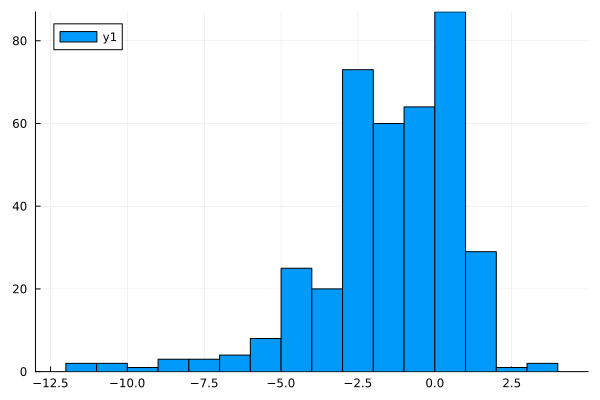

In [67]:
histogram(yt |> vec)

# Calculate the Test Loss

In [68]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [69]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    y_labels = onecold(y_pred, (0, 1, 2))
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [70]:
yth, _ = model(process_inputs(xts, xlts), pst, sttf)

([-8.961657118550477 -4.434727780344819 … -3.2983628970787295 -3.690140065581452; -9.32487061184706 -6.274985579568736 … -0.6242797739818147 -0.8794196471702046; -3.594695038499018 -1.4325711854075982 … -2.138609685702133 -1.660159646677688], (layer_1 = (running_mean = [5.0124492126432925, 9.616352892243489, 17.52105674423773, 28.30641366391307, 41.27152711333373, 80.71897554812635, 89.4275271572422, 89.50799112251822, 89.67981627956817, 89.78702951599479  …  15.871412914187239, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 15.871949485879115, 0.15291454619067543], running_var = [15178.192627907842, 33475.66116950288, 64053.40484324885, 150844.06092135684, 289316.54691077693, 869661.6668876838, 1.1103715446066877e6, 1.1136988046473477e6, 1.1146410157783215e6, 1.115135135158226e6  …  208441.34644549974, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214107305, 208442.96214

In [71]:
accuracy(xts, xlts, yts, model, pst, sttf, 0.2)

93

In [72]:
function confusion_matrix(prediction, truth, threshold::Real)
    truth = hcat(truth .== 1, truth .== 0)
    prediction = hcat(prediction .> threshold, prediction .<= threshold)

    confusion = truth' * prediction
    return confusion
end

confusion_matrix (generic function with 1 method)

In [73]:
using LinearAlgebra: diag

In [74]:
roc = tpr_fpr(yth, yts)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.9609375, 0.9609375, 0.9609375, 0.9609375, 0.9609375, 0.9609375, 0.9609375, 0.9609375, 0.96875, 0.96875], [0.0, 0.0, 0.0, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625, 0.00390625  …  0.8515625, 0.85546875, 0.859375, 0.859375, 0.8671875, 0.8671875, 0.87109375, 0.875, 0.87890625, 0.890625])

In [75]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.00390625
│     ⋮
│     0.87109375
│     0.875
│     0.87890625
│     0.890625
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.9609375
 0.9609375
 0.9609375
 0.9609375
 0.9609375
 0.9609375
 0.9609375
 0.9609375
 0.9609375
 0.96875
 0.96875
 1.0

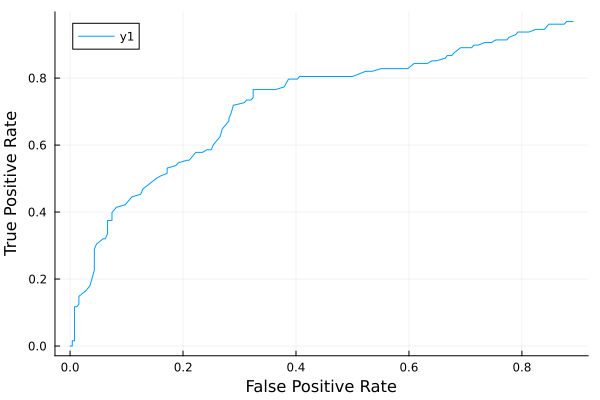

In [76]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [78]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.7478027343749999, 2.2497195079074217e-17)